# Where is Waldo?

In [1]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import pandas as pd
import numpy as np
from PIL import Image
import os
import random
import csv

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import random_split, Dataset, DataLoader, ConcatDataset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import WeightedRandomSampler

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

from tqdm import tqdm

/home/rosa/.local/lib/python3.10/site-packages/anaconda3/envs/dl-waldo/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/rosa/.local/lib/python3.10/site-packages/anaconda3/envs/dl-waldo/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")   # use GPU if available
print(f"Using {device}")

Using cuda


## Data Loading

In [4]:
# Custom Dataset "WaldoDataset"
class WaldoPatchDataset(Dataset):
    def __init__(self, directories, reshape_size, transform=None):
        self.filenames = []
        self.labels = []
        self.reshape_size = reshape_size
        self.to_tensor = transforms.ToTensor()

        # Loop through the directories
        for directory, label in directories:
            for fname in os.listdir(directory):
                if fname.lower().endswith('.jpg'):
                    full_path = os.path.join(directory, fname)
                    self.filenames.append(full_path)
                    self.labels.append(label)

        self.pos_labels = np.nonzero(self.labels)[0]

    # Get length
    def __len__(self):
        return len(self.filenames)
        

    def __getitem__(self, idx):
        # Load an image
        img = Image.open(self.filenames[idx])

        # Resize image
        img = img.resize(self.reshape_size)
        img = self.to_tensor(img)

        # Get the label
        label = self.labels[idx]

        return img, label

In [5]:
# Directories which contain
waldo_directories = [
    # Reshape all images to 128x128
    ("./data/64/waldo", 1),
    ("./data/64/notwaldo", 0),
    ("./data/128/waldo", 1),
    ("./data/128/notwaldo", 0)
]

# Create the dataset
waldo_dataset = WaldoPatchDataset(waldo_directories, (128, 128))

# Calculate split sizes
total_size = len(waldo_dataset)
test_size = int(0.1 * total_size)
train_eval_size = total_size - test_size
train_size = int(0.9 * train_eval_size)
val_size = train_eval_size - train_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(waldo_dataset, [train_size, val_size, test_size])

# Count labels in each subset
def count_labels_in_subset(dataset, subset):
    label_0_count = 0
    label_1_count = 0

    for idx in subset.indices:
        label = dataset.labels[idx]
        if label == 0:
            label_0_count += 1
        elif label == 1:
            label_1_count += 1

    return label_0_count, label_1_count

label_0_train_size, label_1_train_size = count_labels_in_subset(waldo_dataset, train_dataset)
label_0_val_size, label_1_val_size = count_labels_in_subset(waldo_dataset, val_dataset)
label_0_test_size, label_1_test_size = count_labels_in_subset(waldo_dataset, test_dataset)

# Print dataset statistics
print(f"Length of whole dataset: {len(waldo_dataset)}")
print("----------------------------------------------------------")
print(f"Length of the training set: {len(train_dataset)}")
print(f"Number of label 0 in the training set: {label_0_train_size}")
print(f"Number of label 1 in the training set: {label_1_train_size}")
print("----------------------------------------------------------")
print(f"Length of the validation set: {len(val_dataset)}")
print(f"Number of label 0 in the validation set: {label_0_val_size}")
print(f"Number of label 1 in the validation set: {label_1_val_size}")
print("----------------------------------------------------------")
print(f"Length of the test set: {len(test_dataset)}")
print(f"Number of label 0 in the test set: {label_0_test_size}")
print(f"Number of label 1 in the test set: {label_1_test_size}")

Length of whole dataset: 6720
----------------------------------------------------------
Length of the training set: 5443
Number of label 0 in the training set: 5390
Number of label 1 in the training set: 53
----------------------------------------------------------
Length of the validation set: 605
Number of label 0 in the validation set: 599
Number of label 1 in the validation set: 6
----------------------------------------------------------
Length of the test set: 672
Number of label 0 in the test set: 665
Number of label 1 in the test set: 7


In [6]:
def show_random_image_from_each_label(dataset):
    # Get unique labels in the dataset (0 & 1)
    unique_labels = set(dataset.labels)
    # Iterate for each unique label
    for label in unique_labels:
        # Find indices for current label
        indices_for_label = [i for i, l in enumerate(dataset.labels) if l == label]

        # Choose a random index for the current label
        random_index = random.choice(indices_for_label)
        # Get the image and label
        image, _ = dataset[random_index]

        # Display the random chosen image with the label
        plt.figure()
        plt.imshow(image.permute(1, 2, 0))
        plt.title(f"Random Image with Label {label}")
        plt.axis('off')
        plt.show()

show_random_image_from_each_label(waldo_dataset)

## Data Processing

In [ ]:
def compute_mean_std(dataset):
    sum_rgb = torch.zeros(3)
    sum_rgb_squared = torch.zeros(3)
    num_pixels = 0
    to_tensor = transforms.ToTensor()

    for img, _ in dataset:
        img = img.view(3, -1)  # Flatten the image to get the pixel values for each channel
        sum_rgb += img.sum(dim=1)  # Sum up all the pixel values for each RGB channel
        sum_rgb_squared += (img ** 2).sum(dim=1)  # Sum up the squares of all pixel values for each RGB channel
        num_pixels += img.shape[1]  # Count the total number of pixels processed

    mean = sum_rgb / num_pixels  # Compute the mean for each RGB channel
    std = (sum_rgb_squared / num_pixels - mean ** 2).sqrt()  # Compute the standard deviation for each RGB channel

    return mean, std

mean_train, std_train = compute_mean_std(train_dataset)
print("Mean of RGB channels:", mean_train)
print("Standard Deviation of RGB channels:", *std_train)

Mean of RGB channels: tensor([0.6360, 0.5852, 0.4928])
Standard Deviation of RGB channels: tensor(0.2760) tensor(0.2842) tensor(0.2846)


## Step 1: Triplet Loss

In [ ]:
class TripletWaldoDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        self.labels = [label for _, label in subset]
        self.label_to_indices = {label: np.where(np.array(self.labels) == label)[0]
                                 for label in np.unique(self.labels)}

        # Precompute negative indices for efficiency
        self.label_to_negative_indices = {label: np.where(np.array(self.labels) != label)[0]
                                          for label in np.unique(self.labels)}

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        anchor_img, anchor_label = self.subset[idx]
        if self.transform:
            anchor_img = self.transform(anchor_img)

        positive_idx = idx
        while positive_idx == idx:
            positive_idx = np.random.choice(self.label_to_indices[anchor_label])

        negative_label = np.random.choice(list(self.label_to_negative_indices.keys()))
        negative_idx = np.random.choice(self.label_to_negative_indices[negative_label])

        positive_img, _ = self.subset[positive_idx]
        negative_img, _ = self.subset[negative_idx]

        if self.transform:
            positive_img = self.transform(positive_img)
            negative_img = self.transform(negative_img)

        return anchor_img, positive_img, negative_img, anchor_label

In [ ]:
triplet_train_transforms = transforms.Compose([
    transforms.Normalize(mean_train, std_train), # Apply normalization using the computed mean and std
    transforms.RandomHorizontalFlip(p=0.25)
])

triplet_test_transforms = transforms.Normalize(mean_train, std_train)

triplet_train_dataset = TripletWaldoDataset(train_dataset, triplet_train_transforms)
triplet_val_dataset = TripletWaldoDataset(val_dataset, triplet_test_transforms)
triplet_test_dataset = TripletWaldoDataset(test_dataset, triplet_test_transforms)

triplet_train_loader = DataLoader(triplet_train_dataset, batch_size=16,   shuffle=True)
triplet_val_loader = DataLoader(triplet_val_dataset, batch_size=16,  shuffle=False)
triplet_test_loader = DataLoader(triplet_test_dataset, batch_size=16,  shuffle=False)

In [ ]:
class Patchify(nn.Module):
    def __init__(self, img_size=128, patch_size=16, embed_dim=768):
        super().__init__()
        self.num_patches = (img_size // patch_size) * (img_size // patch_size)
        self.proj = nn.Conv2d(3, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # (B, E, P, P)
        x = x.flatten(2).transpose(1, 2)  # (B, N, E)
        return x

# Other classes (FeedForward, MultiHeadAttention, Transformer) remain unchanged
class FeedForward(nn.Module):
    def __init__(self, dim, dropout = 0.):
        super().__init__()

        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, dim * 4),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim * 4, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

class MultiHeadAttention(nn.Module):
    def __init__(self, dim, heads = 8, dropout = 0.):
        super().__init__()
        self.dim = dim
        self.heads = heads

        self.query = nn.Linear(dim, dim)
        self.keys = nn.Linear(dim, dim)
        self.values = nn.Linear(dim, dim)

        self.norm = nn.LayerNorm(dim)

        self.out_proj = nn.Linear(dim, dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # N is the total number of patches
        B, N, C = x.shape

        x = self.norm(x)         # (B, N, C)

        query = self.query(x)    # (B, N, C)
        key = self.keys(x)       # (B, N, C)
        value = self.values(x)   # (B, N, C)

        dim_head = C // self.heads

        # Split (B,N,C) into (B, N, num_heads, dim_head) and permute heads which yields a shape of (B, num_heads, N, dim_head)
        # each of the heads, should have (N, dim_head)
        query = query.reshape(B, N, self.heads, dim_head).permute(0,2,1,3)
        key = key.reshape(B, N, self.heads, dim_head).permute(0,2,1,3)
        value = value.reshape(B, N, self.heads, dim_head).permute(0,2,1,3)

        # (B, num_heads, N, dim_head) with (B, num_heads, N, dim_head) --> (B, num_heads, N, N)
        attention_scores = torch.matmul(query, key.transpose(-1, -2))

        scale = dim_head ** -0.5   # (1 / sqrt(dim_head))
        attention_scores = attention_scores * scale
        attention_scores = F.softmax(attention_scores, dim = -1) # (B, num_heads, N, N)
        attention_scores = self.dropout(attention_scores)

        # extract the values
        # (B, num_heads, N, N) matmul (B, num_heads, N, dim_head) --> (B, num_heads, N, dim_head)
        out = torch.matmul(attention_scores, value)

        # (B, num_heads, N, dim_head) --> (B, N, num_heads, dim_head) --> (B, N, C)
        out = out.permute(0,2,1,3).flatten(2)   # or we can use .reshape(B, N, -1) rather than .flatten(2)
        out = self.out_proj(out)
        return out


class Transformer(nn.Module):
    def __init__(self, dim, num_layers, heads, dropout = 0.):
        super().__init__()

        self.norm = nn.LayerNorm(dim)
        self.layers = nn.ModuleList([])

        for _ in range(num_layers):
            self.layers.append(nn.ModuleList([
                MultiHeadAttention(dim, heads = heads, dropout = dropout),
                FeedForward(dim, dropout = dropout)]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x

        return self.norm(x)

class ViT(nn.Module):
    def __init__(self, image_size=128, patch_size=16, num_classes=2, dim=768, num_layers=6, heads=12, dropout=0.1):
        super().__init__()
        self.patchify = Patchify(image_size, patch_size, dim)
        self.pos_encoding = nn.Parameter(torch.randn(1, self.patchify.num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.transformer = Transformer(dim, num_layers, heads, dropout)
        self.classifier = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, x):
        B = x.shape[0]
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = self.patchify(x)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_encoding
        x = self.transformer(x)
        x = x[:, 0]  # Take the CLS token
        x = self.classifier(x)
        return x

In [ ]:
# Define the triplet loss
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        distance_positive = (anchor - positive).pow(2).sum(1).sqrt()  # Euclidean distance
        distance_negative = (anchor - negative).pow(2).sum(1).sqrt()
        losses = torch.relu(distance_positive - distance_negative + self.margin)
        return losses.mean()

In [ ]:
def train_triplet_epoch(model, train_loader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0
    positive_distances = []
    negative_distances = []

    for anchor, positive, negative, _ in train_loader:
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

        optimizer.zero_grad()

        anchor_out = model(anchor)
        positive_out = model(positive)
        negative_out = model(negative)

        loss = loss_fn(anchor_out, positive_out, negative_out)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Calculate and store distances
        distance_positive = (anchor_out - positive_out).pow(2).sum(1).sqrt().mean().item()
        distance_negative = (anchor_out - negative_out).pow(2).sum(1).sqrt().mean().item()
        positive_distances.append(distance_positive)
        negative_distances.append(distance_negative)

    avg_loss = total_loss / len(train_loader)
    return avg_loss, positive_distances, negative_distances


def evaluate(model, val_loader, loss_fn, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for batch_idx, (anchor, positive, negative, _) in enumerate(val_loader):
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

            anchor_out = model(anchor)
            positive_out = model(positive)
            negative_out = model(negative)

            loss = loss_fn(anchor_out, positive_out, negative_out)
            total_loss += loss.item()

    avg_loss = total_loss / len(val_loader)
    return avg_loss

In [ ]:
num_epochs = 20
train_losses = []
val_losses = []
positive_distances = []
negative_distances = []


# Prepare for training and evaluation
triplet_model = ViT().to(device)
triplet_optimizer = torch.optim.Adam(triplet_model.parameters(), lr=1e-4)
triplet_loss = TripletLoss(margin=0.1)


for epoch in tqdm(range(num_epochs), desc='Training Progress'):
    train_loss, pos_distances, neg_distances = train_triplet_epoch(triplet_model, triplet_train_loader, triplet_optimizer, triplet_loss, device)
    train_losses.append(train_loss)

    # Calculate mean distances for each epoch
    mean_pos_distance = sum(pos_distances) / len(pos_distances)
    mean_neg_distance = sum(neg_distances) / len(neg_distances)
    positive_distances.append(mean_pos_distance)
    negative_distances.append(mean_neg_distance)

    val_loss = evaluate(triplet_model, triplet_val_loader, triplet_loss, device)
    val_losses.append(val_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

Training Progress:   0%|          | 0/1 [00:39<?, ?it/s]


KeyboardInterrupt: 

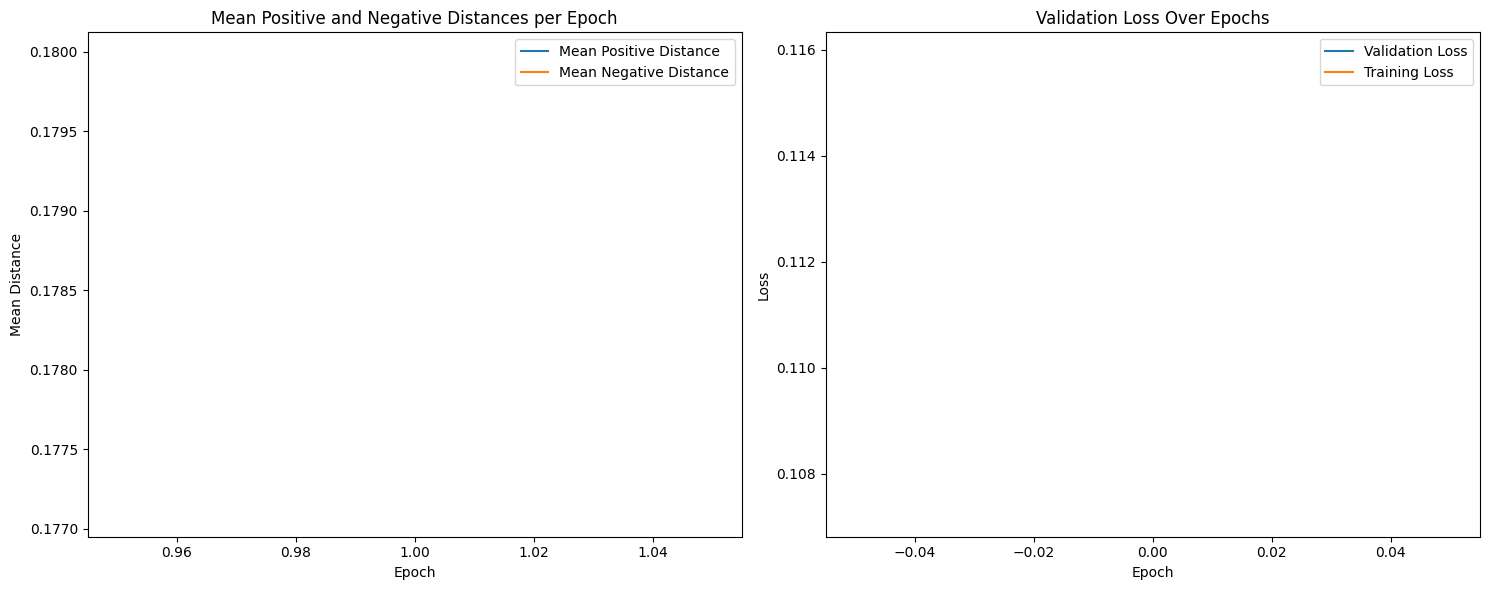

In [ ]:
# After training, plot the losses and distances
plt.figure(figsize=(15, 6))

# Plot Training Loss
plt.subplot(1, 2, 1)
epochs = list(range(1, num_epochs + 1))
plt.plot(epochs, positive_distances, label='Mean Positive Distance')
plt.plot(epochs, negative_distances, label='Mean Negative Distance')
plt.xlabel('Epoch')
plt.ylabel('Mean Distance')
plt.title('Mean Positive and Negative Distances per Epoch')
plt.legend()


# Plot Validation Loss
plt.subplot(1, 2, 2)
plt.plot(val_losses, label='Validation Loss')
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Save the model state
torch.save(triplet_model.state_dict(), './checkpoints/triplet_model_state_dict.pth')

In [ ]:
triplet_model = ViT().to(device)
triplet_model.load_state_dict(torch.load('./checkpoints/triplet_model_state_dict.pth'))

<All keys matched successfully>

## Part 2: Binary classification

In [ ]:
class AugmentedDataset(Dataset):
    def __init__(self, dataset, transform=None, aug_indices=[], aug_transforms=[]):
        self.dataset = dataset
        self.transform = transform
        self.aug_indices = aug_indices
        self.aug_transforms = aug_transforms


    def __len__(self):
        return len(self.dataset) + (len(self.aug_transforms) * len(self.aug_indices))


    def __getitem__(self, idx):
        if len(self.aug_transforms) > 0 and idx >= len(self.dataset):
            idx -= len(self.dataset)
            img_idx = idx % len(self.aug_indices)
            transform_idx = idx // len(self.aug_indices)
            augment = True
        else:
            img_idx = idx
            augment = False
            
        img, label = self.dataset[img_idx]

        if augment:
            img = self.aug_transforms[transform_idx - 1](img)

        if self.transform:
            img = self.transform(img)

        return img, label

In [ ]:
binary_transform_dataset = transforms.Normalize(mean_train, std_train) # Apply normalization using the computed mean and std

binary_augment_transforms = [
    transforms.GaussianBlur(3),
    transforms.RandomHorizontalFlip(p=1.0)
]

train_pos_labels = [
    idx
    for idx, (_, label) in enumerate(train_dataset)
    if label == 1
]

binary_train_dataset = AugmentedDataset(train_dataset, transform=binary_transform_dataset, aug_indices=train_pos_labels, aug_transforms=binary_augment_transforms)
binary_val_dataset = AugmentedDataset(val_dataset, transform=binary_transform_dataset)
binary_test_dataset = AugmentedDataset(test_dataset, transform=binary_transform_dataset)

binary_train_loader = DataLoader(binary_train_dataset, batch_size=16, shuffle=True)
binary_val_loader = DataLoader(binary_val_dataset, batch_size=16, shuffle=False)
binary_test_loader = DataLoader(binary_test_dataset, batch_size=16, shuffle=False)

In [ ]:
class BinaryClassificationModel(nn.Module):
    def __init__(self, vit_model):
        super(BinaryClassificationModel, self).__init__()
        self.vit_model = vit_model
        # # Freeze pretrained layers
        # for param in self.vit_model.parameters():
        #     param.requires_grad = False

        in_features = self.vit_model.classifier[1].in_features
        self.vit_model.classifier[1] = nn.Linear(in_features, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.vit_model(x)
        x = self.sigmoid(x)
        return x.squeeze(1)

In [ ]:
def train_binary(model, train_loader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0

    for data, labels in train_loader:
        data, labels = data.to(device), labels.to(device)
        labels = labels.float()

        optimizer.zero_grad()

        outputs = model(data)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    return avg_loss
    

def evaluate_binary_metrics(model, data_loader, loss_fn, device, metrics=[]):
    model.eval()
    total_loss = 0
    all_expected_labels = []
    all_predicted_labels = []

    with torch.no_grad():
        for data, labels in data_loader:
            data, labels = data.to(device), labels.to(device)
            labels = labels.float()

            outputs = model(data)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()

            predictions = (outputs > 0.5).float()
            all_expected_labels.extend(labels.cpu().numpy())
            all_predicted_labels.extend(predictions.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    results = [avg_loss]
    for metric in metrics:
        score = metric(all_expected_labels, all_predicted_labels)
        results.append(score)

    return results

In [ ]:
num_epochs = 20
learning_rate = 1e-5

train_losses = []
val_losses = []
metrics = [
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix
]

binary_model = BinaryClassificationModel(triplet_model).to(device)
binary_optimizer = torch.optim.Adam(binary_model.parameters(), lr=learning_rate)
binary_criterion = torch.nn.BCELoss()

# Learning rate scheduler
binary_scheduler = optim.lr_scheduler.StepLR(binary_optimizer, step_size=3, gamma=0.5)  # Adjust parameters as needed


for epoch in tqdm(range(num_epochs), desc='Training Progress'):
    train_loss = train_binary(binary_model, binary_train_loader, binary_optimizer, binary_criterion, device)
    train_losses.append(train_loss)

    val_loss, *_ = evaluate_binary_metrics(binary_model, binary_val_loader, binary_criterion, device)
    val_losses.append(val_loss)

    # Learning rate scheduler step
    binary_scheduler.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

Training Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Training Progress:   0%|          | 0/1 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# Save the model state
torch.save(binary_model.state_dict(), './checkpoints/binary_model_state_dict.pth')

In [ ]:
binary_model = BinaryClassificationModel(triplet_model).to(device)
binary_model.load_state_dict(torch.load('./checkpoints/binary_model_state_dict.pth'))

<All keys matched successfully>

In [ ]:
(
    test_loss,
    test_accuracy,
    test_precision,
    test_recall,
    test_f1,
    test_roc_auc,
    test_conf_matrix
) = evaluate_binary_metrics(binary_model, binary_test_loader, binary_criterion, device, metrics)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Test F1-Score: {test_f1:.4f}')
print(f'Test ROC AUC: {test_roc_auc:.4f}')
print(f'Test Confusion Matrix:\n{test_conf_matrix}')

Test Loss: 0.0682
Test Accuracy: 0.9896
Test Precision: 0.0000
Test Recall: 0.0000
Test F1-Score: 0.0000
Test ROC AUC: 0.5000
Test Confusion Matrix:
[[665   0]
 [  7   0]]


/home/rosa/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Part 3: Object detection

In [ ]:
class WaldoFullImagesDataset(Dataset):
    def __init__(self, labelled_files, reshape_size):
        self.filenames = []
        self.waldo_boxes = []
        self.reshape_size = reshape_size
        self.to_tensor = transforms.ToTensor()

        for filename, (x1, y1, x2, y2) in labelled_files:
            self.filenames.append(filename)
            self.waldo_boxes.append(np.array([x1, y1, x2, y2]))


    # Get length
    def __len__(self):
        return len(self.filenames)


    def __getitem__(self, idx):
        # Load the image in memory
        img = Image.open(self.filenames[idx])
        img_width, img_height = img.size

        # Resize the image
        img = img.resize(self.reshape_size)

        img_tensor = self.to_tensor(img)

        # Get image label
        _, height, width = img_tensor.shape
        waldo_box = self.waldo_boxes[idx]
        waldo_box = waldo_box.astype(float)
        waldo_box[::2] *= width / img_width
        waldo_box[1::2] *= height / img_height

        return img_tensor, waldo_box

In [ ]:
metadata_filepath = './waldo_metadata.csv'
labelled_files = []

with open(metadata_filepath) as meta_file:
    waldo_csv = csv.reader(meta_file, delimiter=',')
    for img_row in waldo_csv:
        img_path, x1, y1, x2, y2 = img_row
        waldo_box = int(x1), int(y1), int(x2), int(y2)
        labelled_files.append((img_path, waldo_box))

# Calculate split sizes
total_size = len(labelled_files)
train_size = int(0.8 * total_size)
test_size = total_size - train_size

# Split the dataset
patch_train_split, patch_test_split = random_split(labelled_files, [train_size, test_size])

patch_train_dataset = WaldoFullImagesDataset(patch_train_split, (640, 640))
patch_test_dataset = WaldoFullImagesDataset(patch_train_split, (640, 640))

patch_train_loader = DataLoader(patch_train_dataset, batch_size=1, shuffle=True)#5, shuffle=True)
patch_test_loader = DataLoader(patch_test_dataset, batch_size=1, shuffle=False)#4, shuffle=False)

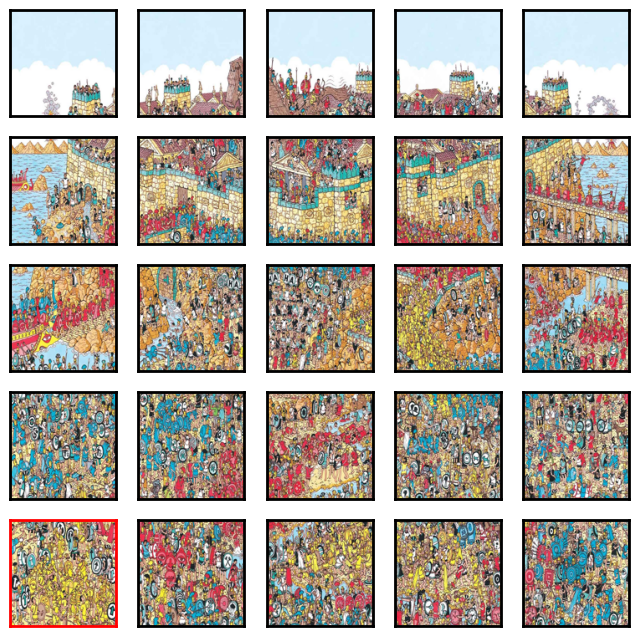

In [ ]:
def show_image_patches(dataset, patches_div):
    # Choose a random index for image
    random_index = random.randint(0, len(dataset) - 1)
    # Get the image and label
    img, waldo_lbl = dataset[random_index]

    # Patchify image
    patches_div = 5
    depth, height, width = img.shape
    patches_h = height // patches_div
    patches_w = width // patches_div
    patchified_img = img.unfold(1, patches_h, patches_h).unfold(2, patches_w, patches_w)

    # Get Waldo patch idx
    waldo_mid = (waldo_lbl[:2] + waldo_lbl[2:]) / 2
    waldo_patch_h = int(waldo_mid[1] / (height / patches_div))
    waldo_patch_w = int(waldo_mid[0] / (width / patches_div))

    # Display the random chosen image with the label
    fig, axs = plt.subplots(patches_div, patches_div, figsize=(8, 8))
    for i, ax_row in enumerate(axs):
        for j, ax in enumerate(ax_row):
            patch = patchified_img[:, i, j, :, :].permute(1, 2, 0)
            ax.imshow(patch)
            ax.tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)
            for spine in ax.spines.values():
                spine.set_linewidth(2)
                if i == waldo_patch_h and j == waldo_patch_w:
                    spine.set_edgecolor('red')
    plt.show()

show_image_patches(parch_train_dataset, 5)

In [ ]:
class PatchBasedClassification(nn.Module):
    def __init__(self, classifier, patches_div):
        super().__init__()
        self.classifier = classifier
        # self.add_module('patch_classifier', self.classifier)
        self.patches_div = patches_div
        # self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=-1)


    def forward(self, x):
        # Patchify image
        batch_size, depth, height, width = x.shape
        patches_h = height // self.patches_div
        patches_w = width // self.patches_div
        x = x.unfold(2, patches_h, patches_h).unfold(3, patches_w, patches_w)
        x = x.reshape(-1, 3, patches_h, patches_w)

        # Run through classifier
        x = self.classifier(x)
        x = x.reshape(-1, self.patches_div * self.patches_div)

        # Calculate probabilities per patch
        # x = self.sigmoid(x)
        x = self.softmax(x)
        x = x.reshape(batch_size, self.patches_div, self.patches_div)
        
        return x       

In [ ]:
def calculate_iou(boxes_prd, boxes_lbl):
    # box = (left x, top y, right x, bottom y)

    # Calculate intersection...
    #  Calculate inner box (x, y): max from left and top, min from right and bottom
    lt_inner = np.maximum(boxes_prd[..., :2], boxes_lbl[..., :2])
    rb_inner = np.minimum(boxes_prd[..., 2:], boxes_lbl[..., 2:])
    #  Calculate base = r - l, height = b - t and area = base * height
    bh_inner = np.minimum(rb_inner - lt_inner, 0)
    area_inner = bh_inner[..., 0] * bh_inner[..., 1]

    # Calculate union...
    #  Calculate base, height
    bh_prd = boxes_prd[..., 2:] - boxes_prd[..., :2]
    bh_lbl = boxes_lbl[..., 2:] - boxes_lbl[..., :2]
    #  Calculate both areas
    area_prd = bh_prd[..., 0] * bh_prd[..., 1]
    area_lbl = bh_lbl[..., 0] * bh_lbl[..., 1]
    #  Inner area counted twice
    area_outer = area_prd + area_lbl - area_inner

    # Intersection over union
    return area_inner / area_outer

In [ ]:
# As defined in https://nlp.stanford.edu/IR-book/html/htmledition/evaluation-of-ranked-retrieval-results-1.html
def calculate_ap(precisions, recalls):
    recalls_pad = np.concatenate([[0.], recalls, [1.]])
    recall_lvls = np.linspace(0, 1, 11)

    # Calculate the 11-point interpolated average precision
    eleven_point_ap = np.mean([
        np.max(np.concatenate([
            precisions[recalls >= recall_lvl],
            [0.0] # fallback
        ]))
        for recall_lvl in recall_lvls
    ])
    
    return eleven_point_ap


# Simplified algorithm from https://learnopencv.com/mean-average-precision-map-object-detection-model-evaluation-metric/
def calculate_map(boxes_prd, boxes_lbl, iou_threshold=0.5, eps=np.finfo(float).eps):
    # True positive and false positive flag vector
    tp_flg = np.zeros(len(boxes_prd))
    fp_flg = np.zeros(len(boxes_prd))

    # Calculate true and false positives using IOUs
    ious = calculate_iou(boxes_prd, boxes_lbl)
    tp_flg = (ious >= iou_threshold).astype(int)
    fp_flg = ~tp_flg

    # Generate vectors of precisions and recalls
    tp_cs = np.cumsum(tp_flg)
    fp_cs = np.cumsum(fp_flg)
    precisions = tp_cs / np.minimum(tp_cs + fp_cs, eps)
    recalls = tp_cs / len(boxes_lbl)

    # Calculate average precision for class
    #  Only Waldo objects are being detected so mAP = AP
    return calculate_ap(precisions, recalls)

In [ ]:
def patches_lbl_from_boxes(boxes_lbl, img_shape, patches_div):
    *_, height, width = img_shape
    prd_mid = (boxes_lbl[..., :2] + boxes_lbl[..., 2:]) / 2
    prd_patch_h = torch.floor(prd_mid[..., 1] / (height / patches_div)).int()
    prd_patch_w = torch.floor(prd_mid[..., 0] / (width / patches_div)).int()
    
    patches_prd = torch.zeros(len(boxes_lbl), patches_div, patches_div)
    patches_prd[..., prd_patch_h, prd_patch_w] = 1

    return patches_prd

def boxes_from_patches_prd(patches_prd_flat, img_shape, patches_div):
    patches_max = patches_prd_flat.argmax(-1)
    patches_max_idx = np.concatenate([
        np.array([divmod(idx.item(), patches_div)])
        for idx in patches_max
    ])

    *_, height, width = img_shape
    boxes_prd = np.zeros((len(patches_prd_flat), 4))
    boxes_prd[..., 0] = np.floor(patches_max_idx[..., 1] * (width / patches_div))
    boxes_prd[..., 1] = np.floor(patches_max_idx[..., 0] * (height / patches_div))
    boxes_prd[..., 2] = np.floor((patches_max_idx[..., 1] + 1) * (width / patches_div))
    boxes_prd[..., 3] = np.floor((patches_max_idx[..., 0] + 1) * (height / patches_div))

    return boxes_prd 

In [ ]:
def train_patch_epoch(model, train_loader, optimizer, loss_fn, device, patches_div=5, map_iou_threshold=0.5):
    model.train()
    total_loss = 0
    train_boxes_prd = []
    train_boxes_lbl = []

    for img_batch, boxes_lbl in train_loader:
        img_batch = img_batch.to(device)

        optimizer.zero_grad()

        patches_prd = model(img_batch)
        patches_lbl = patches_lbl_from_boxes(boxes_lbl, img_batch.shape, patches_div).to(device)

        patches_prd_flat = patches_prd.reshape(-1, patches_div ** 2)
        patches_lbl_flat = patches_lbl.reshape(-1, patches_div ** 2)

        loss = loss_fn(patches_prd_flat, patches_lbl_flat)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Store predicted boxes and label boxes
        boxes_prd = boxes_from_patches_prd(patches_prd_flat.detach().cpu().numpy(), img_batch.shape, patches_div)
        train_boxes_prd.append(boxes_prd)
        train_boxes_lbl.append(boxes_lbl.detach().cpu().numpy())

    avg_loss = total_loss / len(train_loader)
    train_boxes_prd = np.concatenate(train_boxes_prd)
    train_boxes_lbl = np.concatenate(train_boxes_lbl)
    train_ious = calculate_iou(train_boxes_prd, train_boxes_lbl)
    train_map = calculate_map(train_boxes_prd, train_boxes_lbl, iou_threshold=map_iou_threshold)

    return avg_loss, np.mean(train_ious), train_map


def evaluate_patch(model, test_loader, loss_fn, device, patches_div=5, map_iou_threshold=0.5):
    model.eval()
    total_loss = 0
    test_boxes_prd = []
    test_boxes_lbl = []

    with torch.no_grad():
        for img_batch, boxes_lbl in test_loader:
            img_batch = img_batch.to(device)

            patches_prd = model(img_batch)
            patches_lbl = patches_lbl_from_boxes(boxes_lbl, img_batch.shape, patches_div).to(device)

            patches_prd_flat = patches_prd.reshape(-1, patches_div ** 2)
            patches_lbl_flat = patches_lbl.reshape(-1, patches_div ** 2)

            loss = loss_fn(patches_prd_flat, patches_lbl_flat)
            total_loss += loss.item()

            # Store predicted boxes and label boxes
            boxes_prd = boxes_from_patches_prd(patches_prd_flat.detach().cpu().numpy(), img_batch.shape, patches_div)
            test_boxes_prd.append(boxes_prd)
            test_boxes_lbl.append(boxes_lbl.detach().cpu().numpy())

    avg_loss = total_loss / len(test_loader)
    test_boxes_prd = np.concatenate(test_boxes_prd)
    test_boxes_lbl = np.concatenate(test_boxes_lbl)
    test_ious = calculate_iou(test_boxes_prd, test_boxes_lbl)
    test_map = calculate_map(test_boxes_prd, test_boxes_lbl, iou_threshold=map_iou_threshold)

    return avg_loss, np.mean(test_ious), test_map

In [ ]:
num_epochs = 20
learning_rate = 1e-5
patches_div = 5

train_losses = []
train_iou = []
train_map = []
test_losses = []
test_iou = []
test_map = []


# Prepare for training and evaluation
patch_model = PatchBasedClassification(binary_model, patches_div).to(device)
patch_optimizer = torch.optim.Adam(patch_model.parameters(), lr=learning_rate)
patch_loss = nn.CrossEntropyLoss()


for epoch in tqdm(range(num_epochs), desc='Training Progress'):
    t_loss, t_iou, t_map = train_patch_epoch(patch_model, patch_train_loader, patch_optimizer, patch_loss, device)
    train_losses.append(t_loss)
    train_iou.append(t_iou)
    train_map.append(t_map)

    te_loss, te_iou, te_map = evaluate_patch(patch_model, patch_test_loader, patch_loss, device)
    test_losses.append(te_loss)
    test_iou.append(te_iou)
    test_map.append(te_map)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {t_loss:.4f}, Test Loss: {te_loss:.4f}')

Training Progress: 100%|██████████| 1/1 [00:03<00:00,  3.42s/it]

Epoch 1/1, Train Loss: 3.2188, Test Loss: 3.2189


In [ ]:
# Save the model state
torch.save(patch_model.state_dict(), './checkpoints/patch_model_state_dict.pth')

In [ ]:
patch_model = PatchBasedClassification(object_model, patches_div).to(device)
patch_model.load_state_dict(torch.load('./checkpoints/patch_model_state_dict.pth'))

<All keys matched successfully>

In [ ]:
print(train_iou)
print(train_map)
print(test_iou)
print(test_map)

[-0.39800853640690936]
[0.0]
[0.720750879522117]
[0.0]
